In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from patsy import dmatrix, DesignInfo, build_design_matrices
from statsmodels.formula.api import ols
from scipy.interpolate import UnivariateSpline
from mlxtend.feature_selection import SequentialFeatureSelector

from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression

### Problem 6:

(a) Using polynomial regression, highest degree of 4 is preferrable by cross-validation MSE and ANOVA.

(b) Using stepwise functions, cuts count of 14 is preferrable by cross-validation MSE.

In [2]:
Wage = load_data('Wage')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
y = Wage['wage']
age = Wage['age']

age = sm.add_constant(age)
model_list = []

for high in range(2, 11):
    X = age.copy()
    for deg in range(2, high + 1):
        X[f'age_{deg}'] = X['age'] ** deg
    model = sm.OLS(y, X).fit()  
    model_list.append(model)
    
    scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Mean MSE of degree {high}: {-scores.mean()}")

anova_results = anova_lm(*model_list)
print()
print(anova_results)


Mean MSE of degree 2: 1599.5982268539046
Mean MSE of degree 3: 1594.7262162596826
Mean MSE of degree 4: 1593.91410392238
Mean MSE of degree 5: 1595.4331316554849
Mean MSE of degree 6: 1594.9304384006466
Mean MSE of degree 7: 1598.9305138392342
Mean MSE of degree 8: 1599.5018057439347
Mean MSE of degree 9: 1599.4216376646957
Mean MSE of degree 10: 1598.2531692685482

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    2997.0  4.793430e+06      0.0           NaN       NaN       NaN
1    2996.0  4.777674e+06      1.0  15755.693664  9.864068  0.001702
2    2995.0  4.771604e+06      1.0   6070.152124  3.800302  0.051337
3    2994.0  4.770322e+06      1.0   1282.563017  0.802966  0.370280
4    2993.0  4.766389e+06      1.0   3932.257631  2.461844  0.116747
5    2993.0  4.764599e+06     -0.0   1790.494628      -inf       NaN
6    2993.0  4.764136e+06     -0.0    462.435544      -inf       NaN
7    2993.0  4.764981e+06     -0.0   -844.242937       inf       NaN
8    2993.

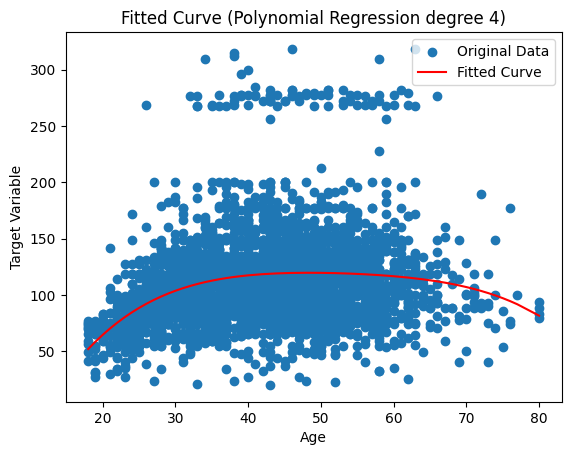

In [4]:
X = age.copy()
for deg in range(2, 4 + 1):
    X[f'age_{deg}'] = X['age'] ** deg
model = sm.OLS(y, X).fit()  

X_sorted = X.sort_values(by='age')  # Sort by age for a smooth curve
predictions = model.predict(X_sorted)

plt.scatter(age['age'], y, label='Original Data')
plt.plot(X_sorted['age'], predictions, color='red', label='Fitted Curve')

plt.xlabel('Age')
plt.ylabel('Target Variable')
plt.legend()
plt.title(f'Fitted Curve (Polynomial Regression degree {deg})')
plt.show()

In [5]:
for n in range(3, 16):
    cut_age = pd.qcut(age['age'], n)
    X = pd.get_dummies(cut_age)
    scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Mean MSE of degree {n}: {-scores.mean()}")

Mean MSE of degree 3: 1660.315910108878
Mean MSE of degree 4: 1640.8034880477321
Mean MSE of degree 5: 1637.7677036735163
Mean MSE of degree 6: 1630.3874966006497
Mean MSE of degree 7: 1624.1869530305435
Mean MSE of degree 8: 1619.0405140011505
Mean MSE of degree 9: 1619.311530409191
Mean MSE of degree 10: 1616.2771950973784
Mean MSE of degree 11: 1619.744234355415
Mean MSE of degree 12: 1617.1225374248122
Mean MSE of degree 13: 1612.9582086519863
Mean MSE of degree 14: 1607.4314577508935
Mean MSE of degree 15: 1613.2801420836176


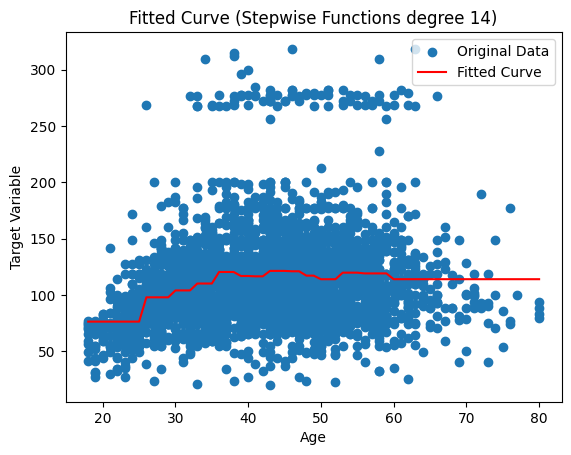

In [6]:
cut_age = pd.qcut(age['age'], 14)
X = pd.get_dummies(cut_age)

model = sm.OLS(y, X).fit()  

X_sorted = X.copy()
X_sorted['age'] = age['age']
X_sorted.sort_values(by='age', inplace=True)
predictions = model.predict(X_sorted.drop(columns='age'))

plt.scatter(age['age'], y, label='Original Data')
plt.plot(X_sorted['age'], predictions, color='red', label='Fitted Curve')

plt.xlabel('Age')
plt.ylabel('Target Variable')
plt.legend()
plt.title('Fitted Curve (Stepwise Functions degree 14)')
plt.show()

### Problem 9:

(a) Using polynomial regression, highest degree of 3 is preferrable by cross-validation.

(b) Using regression splines, knots count of 11 or degree of freedom 10 is preferrable.

In [2]:
Boston = load_data('Boston')

In [3]:
y = Boston['nox']
dis = Boston['dis']

dis = sm.add_constant(dis)
model_list = []

for high in range(2, 11):
    X = dis.copy()
    for deg in range(2, high + 1):
        X[f'dis_{deg}'] = X['dis'] ** deg
    model = sm.OLS(y, X).fit()  
    model_list.append(model)
    
    scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Mean MSE of degree {high}: {-scores.mean()}")

Mean MSE of degree 2: 0.004570384881436261
Mean MSE of degree 3: 0.004647367459422955
Mean MSE of degree 4: 0.004756118478674227
Mean MSE of degree 5: 0.004969650255229157
Mean MSE of degree 6: 0.022083323899155734
Mean MSE of degree 7: 0.0860110442629641
Mean MSE of degree 8: 2.417994415123725
Mean MSE of degree 9: 0.1309500679750631
Mean MSE of degree 10: 84.64977795168056


<Axes: xlabel='dis', ylabel='nox'>

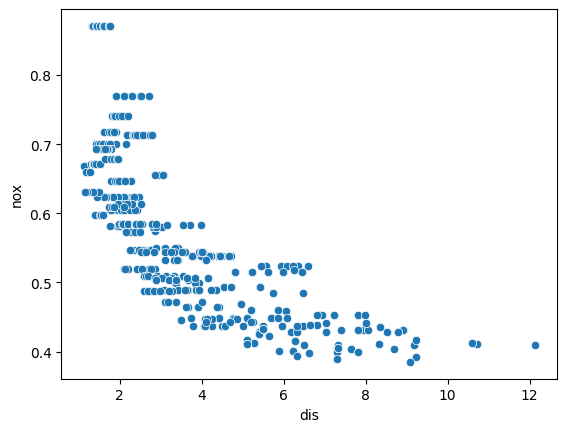

In [4]:
sns.scatterplot(x=Boston['dis'], y=Boston['nox'])

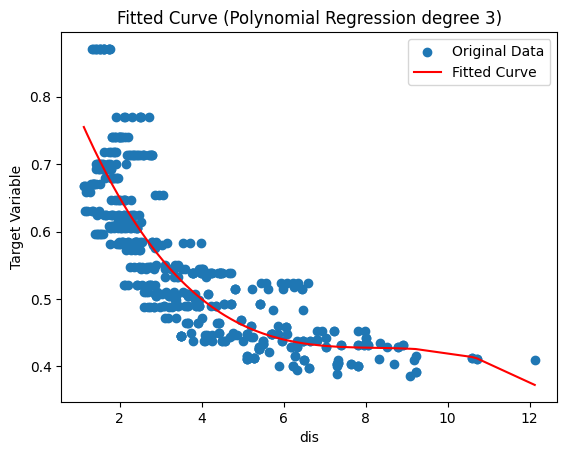

In [5]:
X = dis.copy()
for deg in range(2, 3 + 1):
    X[f'dis_{deg}'] = X['dis'] ** deg
model = sm.OLS(y, X).fit()  

X_sorted = X.sort_values(by='dis')  # Sort by dis for a smooth curve
predictions = model.predict(X_sorted)

plt.scatter(dis['dis'], y, label='Original Data')
plt.plot(X_sorted['dis'], predictions, color='red', label='Fitted Curve')

plt.xlabel('dis')
plt.ylabel('Target Variable')
plt.legend()
plt.title(f'Fitted Curve (Polynomial Regression degree {deg})')
plt.show()

In [31]:
data = pd.DataFrame({'X': dis['dis'], 'y': y})

df = 10
spline_basis = dmatrix("bs(X, df=df, include_intercept=False)", data, return_type='dataframe')

model = sm.GLM(data['y'], spline_basis, family=sm.families.Gaussian()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  506
Model:                            GLM   Df Residuals:                      495
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                       0.0036213
Method:                          IRLS   Log-Likelihood:                 709.67
Date:                Mon, 29 Jul 2024   Deviance:                       1.7925
Time:                        14:55:42   Pearson chi2:                     1.79
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9343
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

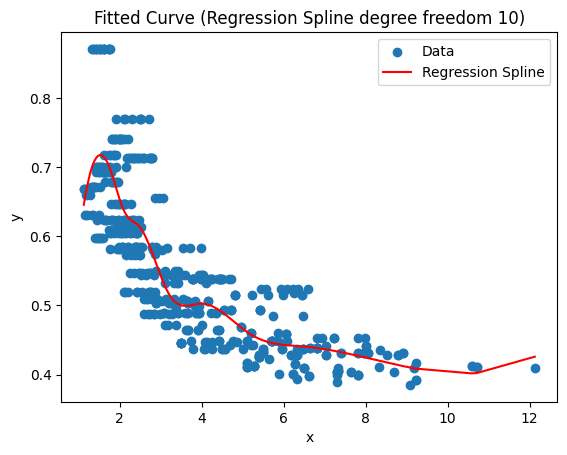

In [32]:
spline_basis_pred = dmatrix(
    "bs(x_pred, df=df, include_intercept=False)", 
    {"x_pred": sorted(dis['dis'])}, 
    return_type='dataframe'
    )
x_pred = sorted(dis['dis'])
y_pred = model.predict(spline_basis_pred)

plt.scatter(dis['dis'], y, label='Data')
plt.plot(x_pred, y_pred, color='red', label='Regression Spline')
plt.title(f'Fitted Curve (Regression Spline degree freedom {df})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [38]:
df_list = range(3, 21)
n_splits = 5  
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1) 

deg, mse_cv = [], []
for df in df_list:
    mse_list = []  

    for train_index, test_index in kf.split(dis['dis']):
        X_train, X_test = dis['dis'][train_index], dis['dis'][test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_data = pd.DataFrame({'X': X_train, 'y': y_train})
        test_data = pd.DataFrame({'X': X_test})

        spline_basis_train = dmatrix(f"bs(X, df={df}, include_intercept=False)", train_data, return_type='dataframe')
        model = sm.GLM(train_data['y'], spline_basis_train, family=sm.families.Gaussian()).fit()

        spline_basis_test = dmatrix(f"bs(X, df={df}, include_intercept=False)", test_data, return_type='dataframe')
        y_pred = model.predict(spline_basis_test)

        mse = ((y_pred - y_test) ** 2).mean()
        mse_list.append(mse)

    avg_mse = np.mean(mse_list)

    deg.append(df)
    mse_cv.append(avg_mse)
    
    print(f"df: {df}, Average MSE: {avg_mse}")

df: 3, Average MSE: 0.004173609139078547
df: 4, Average MSE: 0.003984033627969603
df: 5, Average MSE: 0.003771887225879007
df: 6, Average MSE: 0.0037260182146908565
df: 7, Average MSE: 0.003691651484683877
df: 8, Average MSE: 0.0036723040423706247
df: 9, Average MSE: 0.0036862076019221457
df: 10, Average MSE: 0.003598968299394948
df: 11, Average MSE: 0.003612756558296753
df: 12, Average MSE: 0.003624944047533253
df: 13, Average MSE: 0.0036257402276973576
df: 14, Average MSE: 0.00361849379069554
df: 15, Average MSE: 0.0036229374662362515
df: 16, Average MSE: 0.0036546630619811596
df: 17, Average MSE: 0.003669068625535778
df: 18, Average MSE: 0.003668616030702809
df: 19, Average MSE: 0.0036657502109647827
df: 20, Average MSE: 0.0036984077813206097


Text(0.5, 0, 'Degree of Freedom')

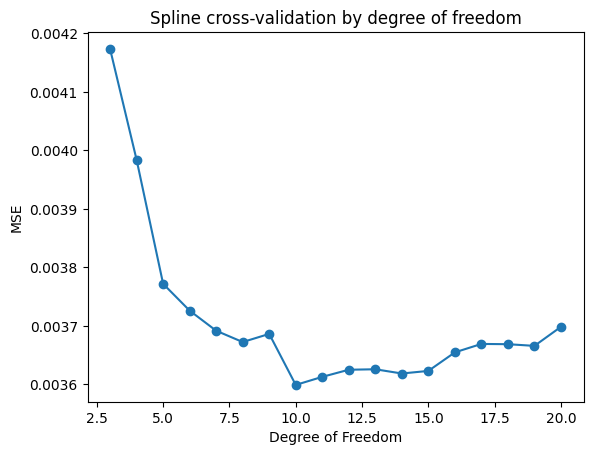

In [39]:
plt.plot(deg, mse_cv, marker='o')
plt.title('Spline cross-validation by degree of freedom')
plt.ylabel('MSE')
plt.xlabel('Degree of Freedom')

### Problem 10:

(a) Use a stepwise function to obtain significant features

(b) Use these features to fit a GAM on prediction 'Outstate'

In [2]:
College = load_data('College')
College.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [3]:
X = College.drop(columns='Outstate')
X['Private'] = X['Private'].map({'Yes': 1, 'No': 0})
X = sm.add_constant(X)
y = College['Outstate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sfs = SequentialFeatureSelector(
    LinearRegression(),
    k_features=5,
    forward=True,
    scoring='neg_mean_squared_error',
    cv=None
    )
selected_features = sfs.fit(X_train, y_train)
selected_features.k_feature_names_

('Private', 'Room.Board', 'Terminal', 'perc.alumni', 'Expend')

In [4]:
feature_list = list(selected_features.k_feature_names_)
X_train, X_test = X_train[feature_list], X_test[feature_list]

gam = LinearGAM(s_gam(4)).fit(X_train, y_train)
y_pred = gam.predict(X_test)

Text(0, 0.5, 'Predicted values')

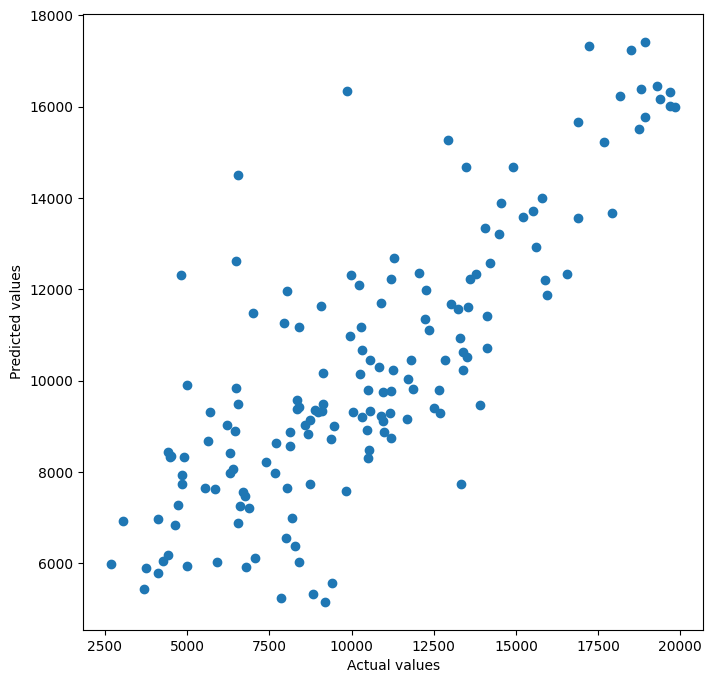

In [8]:
ax = plt.subplots(figsize=(8, 8))[1]
ax.scatter(y_test.values, y_pred)
ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')

In [102]:
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.4837
Link Function:                     IdentityLink Log Likelihood:                                -10303.9329
Number of Samples:                          621 AIC:                                            20628.8332
                                                AICc:                                           20629.2282
                                                GCV:                                          6592088.6865
                                                Scale:                                        6411128.7871
                                                Pseudo R-Squared:                                   0.6006
Feature Function                  Lam

/tmp/ipykernel_1995/3564666153.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
